In [2]:
import os
import pandas as pd
import yfinance as yf
import numpy as np

msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)
    

### Open – the price the stock opened at
### High – the highest price during the day
### Low – the lowest price during the day
### Close – the closing price on the trading day
### Volume – how many shares were traded

In [7]:
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.055380,0.063524,0.055380,0.060809,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060809,0.064067,0.060809,0.062980,308160000,0.0,0.0
1986-03-17 05:00:00,0.062980,0.064609,0.062980,0.064067,133171200,0.0,0.0
1986-03-18 05:00:00,0.064067,0.064609,0.061894,0.062437,67766400,0.0,0.0
1986-03-19 05:00:00,0.062437,0.062980,0.060809,0.061351,47894400,0.0,0.0


<AxesSubplot: >

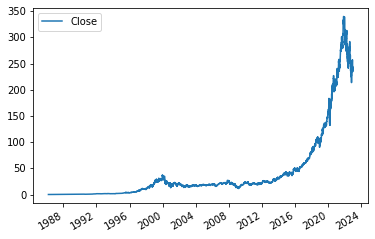

In [12]:
msft_hist.plot.line(y="Close", use_index=True)

In [33]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [34]:
data.head()

,Actual_Close,Target
1986-03-13 05:00:00,0.060809,NaN
1986-03-14 05:00:00,0.062980,1.0
1986-03-17 05:00:00,0.064067,1.0
1986-03-18 05:00:00,0.062437,0.0
1986-03-19 05:00:00,0.061351,0.0


In [35]:
# his is to ensure that we’re predicting future prices using past data.
# If we didn’t do this, we’d be using data from 03-14 to predict prices on 03-14. 
# Instead, we need to use data from 03-13 to predict prices on 03-14. 

msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.055380,0.063524,0.055380,0.060809,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.060809,0.064067,0.060809,0.062980,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062980,0.064609,0.062980,0.064067,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.064067,0.064609,0.061894,0.062437,6.776640e+07,0.0,0.0


In [36]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:] # iloce to remove the 1st row

In [45]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062980,1.0,0.060809,1.031789e+09,0.055380,0.063524,0.055380
1986-03-17 05:00:00,0.064067,1.0,0.062980,3.081600e+08,0.060809,0.064067,0.060809
1986-03-18 05:00:00,0.062437,0.0,0.064067,1.331712e+08,0.062980,0.064609,0.062980
1986-03-19 05:00:00,0.061351,0.0,0.062437,6.776640e+07,0.064067,0.064609,0.061894
1986-03-20 05:00:00,0.059723,0.0,0.061351,4.789440e+07,0.062437,0.062980,0.060809


# Creating a machine learning model

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import precision_score

# Create a random forest classification model  
# Set min_samples_split high to ensure we don't overfit
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [40]:
# train it on the last 100 rows of the dataset

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])


# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5151515151515151

In [25]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-13 05:00:00,0.060809,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.062980,1.0,0.060809,1.031789e+09,0.055380,0.063524,0.055380
1986-03-17 05:00:00,0.064067,1.0,0.062980,3.081600e+08,0.060809,0.064067,0.060809
1986-03-18 05:00:00,0.062437,0.0,0.064067,1.331712e+08,0.062980,0.064609,0.062980
1986-03-19 05:00:00,0.061351,0.0,0.062437,6.776640e+07,0.064067,0.064609,0.061894


<AxesSubplot: >

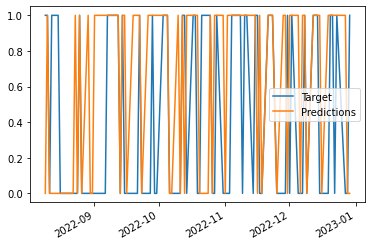

In [43]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

# Backtesting

The last 100 days may have had atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions.

To test on more days, we’ll need to backtest. Backtesting ensures that we only use data from before the day that we’re predicting.


- We’ll take the first 1000 rows of the data as our training set
- We’ll take the next 750 rows as our testing set
- We’ll fit our machine learning model to the training set
- We’ll make predictions on the test set

In [63]:
i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [68]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [69]:
preds.head()

1990-02-27 05:00:00    1.0
1990-02-28 05:00:00    1.0
1990-03-01 05:00:00    1.0
1990-03-02 05:00:00    1.0
1990-03-05 05:00:00    1.0
dtype: float64

- Generate predictions on our train and test set
- Combine those predictions with the actual target
- Add all the predictions into one list

We’ll get predictions for all but the first 1000 rows of the dataset. This is because there is no previous data we can use to predict those rows.

In [70]:
predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

In [76]:
predictions[0].head()

,Target,Predictions
1990-02-27 05:00:00,0.0,1.0
1990-02-28 05:00:00,1.0,1.0
1990-03-01 05:00:00,1.0,1.0
1990-03-02 05:00:00,1.0,1.0
1990-03-05 05:00:00,1.0,1.0


In [77]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [78]:
predictions = backtest(data, model, predictors)

In [81]:
predictions["Predictions"].value_counts()

0.0    7531
1.0     744
Name: Predictions, dtype: int64

In [82]:
predictions["Target"].value_counts()

1.0    4186
0.0    4089
Name: Target, dtype: int64

As you can see, the algorithm only predicted that the price would go up 739 times. In the Target, you see that the price actually went up 3945 times. So the algorithm predicted the price would go up far fewer times than it actually did. This means that the algorithm had low recall, which is the % chance of finding all of the days where the price went up.

This is because we used .6 as a threshold for whether the price would go up or not. If we used a lower threshold, we would increase recall, but lower precision. Since we want to minimize our risk, we want to maximize precision. So it’s okay if the algorithm only predicts the price will go up on very few days.

In [83]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5013440860215054